In [2]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '..'))

In [3]:
import logging
logging.basicConfig(level=logging.DEBUG)

In [4]:
import pyvsem
from pyvsem.utilities import load_pickle, save_pickle

import pickle
import numpy as np
import heapq
import cv2

import sklearn.metrics

import theano
import theano.tensor as T

import nolearn
from nolearn.lasagne import PrintLog, PrintLayerInfo

from IPython.display import Image
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imshow

Using cuDNN version 5103 on context None
Mapped name None to device cuda2: Tesla K40c (0000:8A:00.0)
/home/bermeit/.virtualenvs/pyvsem/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
DATA_SET = 'metmuseum'
DATA_DIR = os.path.join(os.getcwd(), '..', 'data', DATA_SET)
DATA_DIR = os.path.abspath(DATA_DIR)
print("Using '{}' as data directory".format(DATA_DIR))
if not os.path.isdir(DATA_DIR):
    print("Data dir does not exist")

print("Possible nets:")
print("\n".join(sorted([os.path.splitext(os.path.basename(p))[0] for p in os.listdir(DATA_DIR) if p.endswith('.pickle') and p.startswith('pretrained')])))

Using '/home/bermeit/pyvsem/data/metmuseum' as data directory
Possible nets:
pretrained_net26_multi_class_3x120x120_aug_256_params
pretrained_net26_multi_class_3x120x120_aug_256_training_history


In [6]:
import logging
import os
from pyvsem.neuralnets.options import ImageIterator
import nolearn_utils.hooks
from nolearn_utils.iterators import (
    ReadImageBatchIteratorMixin,
    ShuffleBatchIteratorMixin,
    AffineTransformBatchIteratorMixin,
    BufferedBatchIteratorMixin,
    make_iterator
)

/home/bermeit/.virtualenvs/pyvsem/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
NET = '26'
TASK = 'multi_class'
COLORS = 3
WIDTH = 120
AUG = True
BATCH_SIZE = 256

CURRENT_RUN = 'pretrained_net{}_{}_{}x{}x{}_{}_{}'.format(NET, TASK, COLORS, WIDTH, WIDTH, 'aug' if AUG else 'noaug', BATCH_SIZE)

image_size = (WIDTH, WIDTH)
image_shape = (COLORS, WIDTH, WIDTH)

print("using run: {}".format(CURRENT_RUN))

using run: pretrained_net26_multi_class_3x120x120_aug_256


In [8]:
dp = load_pickle(os.path.join(DATA_DIR, "PROVIDER_multi_class.pickle"))

In [9]:
train_iterator_mixins = [
    ReadImageBatchIteratorMixin,
    ShuffleBatchIteratorMixin,
    BufferedBatchIteratorMixin
]
train_iterator = make_iterator('train_iterator', train_iterator_mixins)
train_iterator_args = {
    'read_image_size': image_size,
    'read_image_as_gray': COLORS == 1,
    'batch_size': BATCH_SIZE,
    'buffer_size': 5
}
train_iterator = train_iterator(**train_iterator_args)

test_iterator_mixins = [
    ReadImageBatchIteratorMixin,
    BufferedBatchIteratorMixin
]
test_iterator = make_iterator('test_iterator', test_iterator_mixins)
test_iterator_args = {
    'read_image_size': image_size,
    'read_image_as_gray': COLORS == 1,
    'batch_size': BATCH_SIZE,
    'buffer_size': 5,
}
test_iterator = test_iterator(**test_iterator_args)

In [10]:
from pyvsem.neuralnets.playground import net_26 as net_factory

In [11]:
# recreate net to test stuff
net = net_factory.create_net(
    input_shape=image_shape,
    y=dp.get_all_tags(),
    train_iterator=train_iterator,
    test_iterator=test_iterator,
    max_epochs=100,
    on_epoch_finished=[]  # no training, so this is not needed
)

In [12]:
from nolearn.lasagne import PrintLayerInfo
p = PrintLayerInfo()
p(net)

# Neural Network with 45117882 learnable parameters

## Layer information

name      size          total    cap.Y    cap.X    cov.Y    cov.X    filter Y    filter X    field Y    field X
--------  ----------  -------  -------  -------  -------  -------  ----------  ----------  ---------  ---------
input     3x120x120     43200   100.00   100.00   100.00   100.00         120         120        120        120
conv1_1   64x120x120   921600   100.00   100.00     2.50     2.50           3           3          3          3
pool1     64x60x60     230400   100.00   100.00     2.50     2.50           3           3          3          3
conv2_1   128x60x60    460800    85.71    85.71     5.83     5.83           6           6          7          7
pool2     128x30x30    115200    85.71    85.71     5.83     5.83           6           6          7          7
conv3_1   256x30x30    230400    80.00    80.00    12.50    12.50          12          12         15         15
conv_2    256x30x30    230400

In [13]:
# load parameters from trained net
net.load_params_from(os.path.join(DATA_DIR, "{}_params.pickle".format(CURRENT_RUN)))

Loaded parameters to layer 'conv1_1' (shape 64x3x3x3).
Loaded parameters to layer 'conv1_1' (shape 64).
Loaded parameters to layer 'conv2_1' (shape 128x64x3x3).
Loaded parameters to layer 'conv2_1' (shape 128).
Loaded parameters to layer 'conv3_1' (shape 256x128x3x3).
Loaded parameters to layer 'conv3_1' (shape 256).
Loaded parameters to layer 'conv_2' (shape 256x256x3x3).
Loaded parameters to layer 'conv_2' (shape 256).
Loaded parameters to layer 'conv4_1' (shape 512x256x3x3).
Loaded parameters to layer 'conv4_1' (shape 512).
Loaded parameters to layer 'conv4_2' (shape 512x512x3x3).
Loaded parameters to layer 'conv4_2' (shape 512).
Loaded parameters to layer 'conv5_1' (shape 512x512x3x3).
Loaded parameters to layer 'conv5_1' (shape 512).
Loaded parameters to layer 'conv5_2' (shape 512x512x3x3).
Loaded parameters to layer 'conv5_2' (shape 512).
Loaded parameters to layer 'fc6' (shape 4608x4096).
Loaded parameters to layer 'fc6' (shape 4096).
Loaded parameters to layer 'fc7' (shape 4096

In [14]:
X_train = load_pickle(
    os.path.join(DATA_DIR, "XTRAIN_multi_class.pickle")) 
X_test = load_pickle(
    os.path.join(DATA_DIR, "XTEST_multi_class.pickle"))
y_train = load_pickle(
    os.path.join(DATA_DIR, "YTRAIN_multi_class.pickle"))
y_test = load_pickle(
    os.path.join(DATA_DIR, "YTEST_multi_class.pickle"))
X_train = [os.path.join('..', p) for p in X_train]
X_test = [os.path.join('..', p) for p in X_test]

In [15]:
print("X_train: {:6} images".format(len(X_train)))
print("X_test : {:6} images".format(len(X_test)))

X_train:    964 images
X_test :    242 images


In [16]:
TAGS = dp.get_all_tags()
print("{} different tags".format(len(TAGS)))

58 different tags


target class: 'Sideboard'
image path:   '/home/bermeit/pyvsem/data/metmuseum/images/7508_10.jpg'


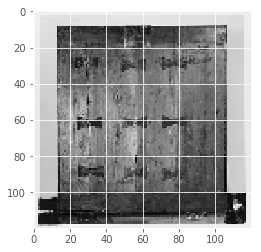

In [41]:
TI = 120
print("target class: '{}'".format(dp.inverse_transform(y_test[TI])))
print("image path:   '{}'".format(X_test[TI]))
im = test_iterator.transform(np.array([X_test[TI]]), None)[0][0]
im = im.transpose(1, 2, 0)
imshow(im)

In [42]:
# get prediction for the test image
pred_test = net.predict(np.array([X_test[TI]]))

print("predictions:")
print(dp.inverse_transform(pred_test))

predictions:
['Bedstead']


In [35]:
indices = []
for idx, i in enumerate([dp.inverse_transform(x) for x in y_test]):
    if 'Sideboard' == i:
        indices.append(idx)
indices

[47, 54, 120, 225, 234]

In [34]:
dp.transform(['Building'])

array([8], dtype=int32)

In [66]:
pred_all = net.predict(np.array(X_test))
pred_all

array([14, 12, 12, 28, 44, 41, 14, 46,  1,  9, 14, 28,  9, 14, 41,  1, 12,
        1,  1, 45,  1, 48, 14, 28, 24,  4, 28,  1, 20, 44,  4, 28, 10, 42,
       57,  4, 14, 14, 12,  4, 14, 46, 21, 21, 46,  4, 41, 29,  1, 57, 12,
       21,  1,  4,  4, 37, 45,  1,  1, 14, 44, 41, 28, 10,  1, 34, 14, 29,
       34, 28,  1, 21, 14, 10, 34, 14,  1, 10, 14, 44,  1, 45, 14, 33, 14,
        1,  1, 10,  4, 20, 20, 49,  9, 28,  5, 21, 34, 30, 46,  1, 28, 21,
        1, 45, 21,  1,  9, 12,  1, 19,  1,  5, 45, 21, 14,  9,  4,  4,  1,
        1, 24, 44, 28, 46,  1, 46,  1,  9,  1, 12, 42, 28, 31,  0, 21, 44,
       46, 28, 14, 12, 42,  6, 21,  1, 21, 46,  5, 42, 28, 46, 34, 57, 46,
       25, 28,  9, 21, 29, 46,  1, 28,  1, 41, 12,  1, 45, 57, 33, 20,  1,
        4, 12,  4, 32, 12,  1, 44,  4, 44, 45, 14, 41, 14,  5, 10,  1, 12,
        1, 28,  8, 14, 32,  4, 46,  1, 51, 30,  4,  4, 51,  5, 46,  4, 57,
       30, 22, 51, 24, 28, 12, 14, 28, 31, 14,  8, 12, 45, 45,  1, 14, 51,
       14, 28, 34, 46, 12

In [67]:
print("classification report:")
cr = sklearn.metrics.classification_report(
    y_true=dp.inverse_transform(y_test),
    y_pred=dp.inverse_transform(pred_all),
    digits=3)
print(cr)

classification report:
                        precision    recall  f1-score   support

     Architect‘s table      1.000     1.000     1.000         1
             Arm chair      0.316     0.706     0.436        17
              Armchair      0.000     0.000     0.000         1
  Athenienne washstand      0.000     0.000     0.000         1
              Bedstead      0.056     0.333     0.095         3
       Bonheur du jour      0.600     1.000     0.750         3
                   Box      0.000     0.000     0.000         0
              Building      1.000     0.600     0.750         5
       Bureau bookcase      1.000     0.538     0.700        13
     Cabinet secretary      0.500     0.273     0.353        11
            Card table      0.467     0.467     0.467        15
          Centre piece      0.000     0.000     0.000         1
                 Chair      0.926     0.676     0.781        37
            Chandelier      0.000     0.000     0.000         3
      Chest of d

/home/bermeit/.virtualenvs/pyvsem/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bermeit/.virtualenvs/pyvsem/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [127]:
_, _, f1, s = sklearn.metrics.precision_recall_fscore_support(y_true=y_test, y_pred=pred_all)

/home/bermeit/.virtualenvs/pyvsem/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bermeit/.virtualenvs/pyvsem/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [140]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 1  0  0 ...,  0  0  0]
 [ 0 12  0 ...,  0  0  0]
 [ 0  1  0 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  4]]


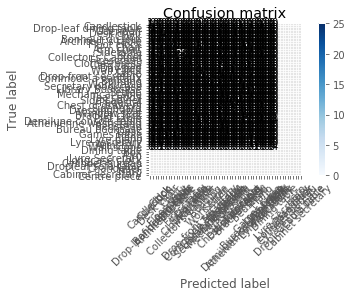

In [141]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(confusion_matrix(y_test, pred_all), dp.all_tags)

In [75]:
from collections import Counter
Counter([dp.inverse_transform(y) for y in y_test]).most_common()

[('Chair', 37),
 ('Arm chair', 17),
 ('Card table', 15),
 ('Cylinder bureau', 14),
 ('Bureau bookcase', 13),
 ('Cabinet secretary', 11),
 ('Settee', 10),
 ('Secretary bookcase', 10),
 ('Drop-front secretary', 9),
 ('Pier table', 9),
 ('Commode à vantaux', 9),
 ('Work table', 6),
 ('Day bed', 5),
 ('Sideboard', 5),
 ('Building', 5),
 ('Mechanical table', 5),
 ('Gueridon', 5),
 ('Dressing table', 4),
 ('Bonheur du jour', 3),
 ('Drop-leaf dining table', 3),
 ('Chandelier', 3),
 ('Floor clock', 3),
 ('Table', 3),
 ('Bedstead', 3),
 ('Firescreen', 3),
 ('Desk', 3),
 ('Games table', 2),
 ('Clothes press', 2),
 ('Collector‘s Cabinet', 2),
 ('Longcase clock', 2),
 ('Pedestal', 2),
 ('Stool', 2),
 ('Urn', 2),
 ('Dining table', 2),
 ('Desk chair', 2),
 ('Armchair', 1),
 ('Architect‘s table', 1),
 ('Demilune console table', 1),
 ('Centre piece', 1),
 ('Clock', 1),
 ('Wall clock', 1),
 ('Athenienne washstand', 1),
 ('Sidetable', 1),
 ('Tea caddy', 1),
 ('Window seat', 1),
 ('Chest of drawers', 1)]

In [100]:
from collections import OrderedDict

In [171]:
list(set([dp.inverse_transform(x) for x in y_test]))

['Drop-front secretary',
 'Card table',
 'Chandelier',
 'Games table',
 'Architect‘s table',
 'Clock',
 'Arm chair',
 'Collector‘s Cabinet',
 'Bonheur du jour',
 'Cylinder bureau',
 'Armchair',
 'Drop-leaf dining table',
 'Longcase clock',
 'Day bed',
 'Pedestal',
 'Demilune console table',
 'Centre piece',
 'Bureau bookcase',
 'Stool',
 'Urn',
 'Dressing table',
 'Sideboard',
 'Pier table',
 'Commode à vantaux',
 'Clothes press',
 'Building',
 'Settee',
 'Wall clock',
 'Athenienne washstand',
 'Floor clock',
 'Mechanical table',
 'Table',
 'Bedstead',
 'Sidetable',
 'Secretary bookcase',
 'Cabinet secretary',
 'Firescreen',
 'Gueridon',
 'Work table',
 'Desk',
 'Dining table',
 'Tea caddy',
 'Window seat',
 'Chest of drawers',
 'Desk chair',
 'Chair']

/home/bermeit/.virtualenvs/pyvsem/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bermeit/.virtualenvs/pyvsem/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


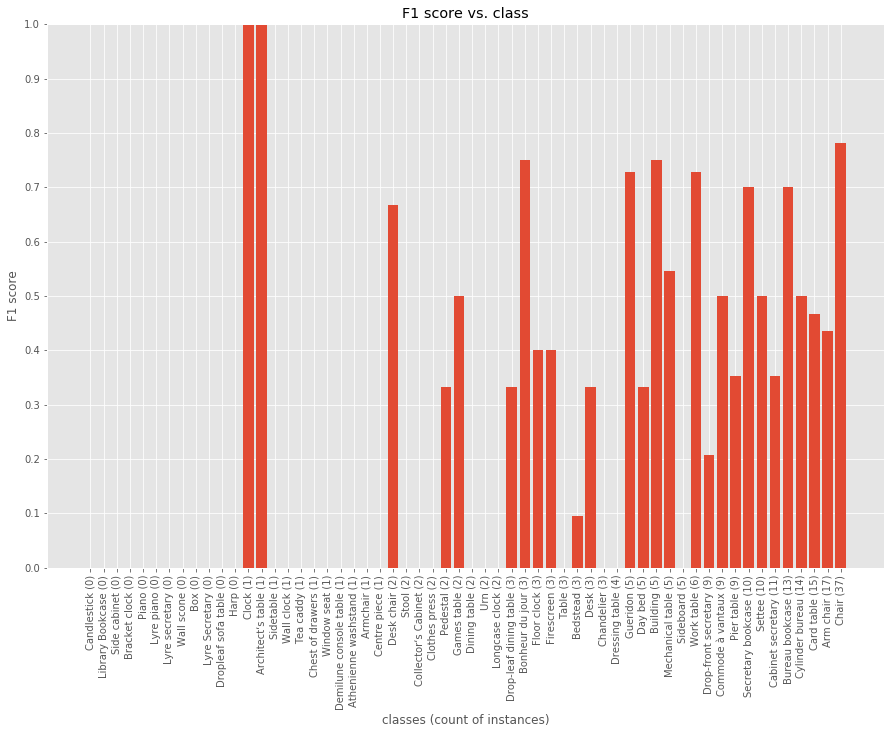

In [193]:
_, _, fscore, support = sklearn.metrics.precision_recall_fscore_support(
    y_true=[dp.inverse_transform(x) for x in y_test],
    y_pred=[dp.inverse_transform(x) for x in pred_all],
    labels=dp.all_tags,
    average=None
)

# plot f1 / support
width = 0.8
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('F1 score vs. class')

ax.set_xlabel('classes (count of instances)')
ax.set_ylabel('F1 score')

ax.set_yticks(np.arange(0.0, 1.1, 0.1))
ax.set_ylim(0.0, 1.0)

ax.set_xticks(range(len(fscore)))
ax.set_xticklabels(
    ["{} ({})".format(dp.all_tags[i], sup) for i, sup in sorted(enumerate(support), key=lambda x: x[1])],
    rotation='vertical')
#ax.set_xlim(width, len(s) + width)

bar = plt.bar(
    range(len(fscore)),
    [f for f, _ in sorted(zip(fscore, support), key=lambda x: x[1])],
    width=width)

plt.show()

In [187]:
dp.all_tags

array(['Candlestick', 'Drop-leaf dining table', 'Gueridon', 'Desk chair',
       'Clock', 'Bonheur du jour', 'Architect‘s table', 'Floor clock',
       'Chair', 'Arm chair', 'Sidetable', 'Stool', 'Collector‘s Cabinet',
       'Firescreen', 'Clothes press', 'Card table', 'Day bed',
       'Wall clock', 'Table', 'Drop-front secretary', 'Commode à vantaux',
       'Building', 'Work table', 'Secretary bookcase', 'Library Bookcase',
       'Settee', 'Mechanical table', 'Tea caddy', 'Side cabinet',
       'Pedestal', 'Chest of drawers', 'Sideboard', 'Dressing table',
       'Window seat', 'Bracket clock', 'Pier table',
       'Demilune console table', 'Athenienne washstand', 'Bedstead',
       'Bureau bookcase', 'Desk', 'Games table', 'Piano', 'Lyre piano',
       'Lyre secretary', 'Armchair', 'Wall scone', 'Dining table', 'Box',
       'Urn', 'Lyre Secretary', 'Longcase clock', 'Cylinder bureau',
       'Dropleaf sofa table', 'Chandelier', 'Harp', 'Cabinet secretary',
       'Centre piece']

In [83]:
res[8]

('Floor clock', 0.70000000000000007)

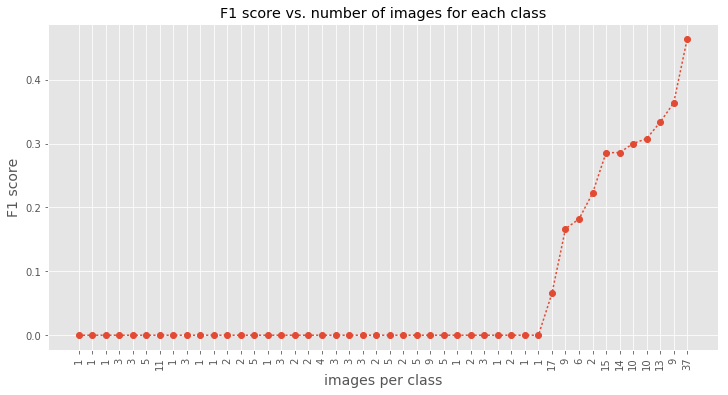

In [46]:
# plot f1 / support
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('F1 score vs. number of images for each class')

ax.set_xlabel('images per class', fontsize=14)
ax.set_ylabel('F1 score', fontsize=14)

sorted_f1 = sorted(enumerate(f1), key=lambda x: x[1])

ax.set_xticks(range(len(sorted_f1)))
ax.set_xticklabels([s[idx] for idx, _ in sorted_f1], rotation='vertical')

#ax.set_ylim(0.0, 1.0)
ax.set_yticks(np.arange(0.0, 1.1, 0.1))

plot = plt.plot(
    [val for _, val in sorted_f1], 'o:'
)

#plt.savefig("plot_f1_support_multiclass.pdf", bbox_inches='tight', transparent=True)
#plt.savefig("plot_f1_support_multiclass.png", bbox_inches='tight', transparent=True, dpi=120)

plt.show()

In [47]:
print("std f1 : ±{:.4f}".format(np.std(f1)))
print("mean f1:  {:.4f}".format(np.mean(f1)))

std f1 : ±0.1258
mean f1:  0.0647


In [48]:
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(
            y_true=y_test,
            y_pred=pred_all)))

accuracy score: 0.2396694214876033


In [145]:
def plot_confusion_matrix(cm, labels, name):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(cm)
    
    fig = plt.gcf()
    fig.set_size_inches(len(labels) // 3, len(labels) // 3)
    
    ax.set_frame_on(False)
    
    ticks = np.arange(cm.shape[0]) + 0.5
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    ax.set_xticklabels(labels, minor=False)
    ax.set_yticklabels(labels, minor=False)
    
    plt.xticks(rotation=90)
    
    ax.grid(False)
    
    ax = plt.gca()
    
    for t in ax.xaxis.get_major_ticks():
        t.tick10n = False
        t.tick20n = False
    for t in ax.yaxis.get_major_ticks():
        t.tick10n = False
        t.tick20n = False
    
    fig.savefig('{}.pdf'.format(name), bbox_inches='tight', transparent=True)

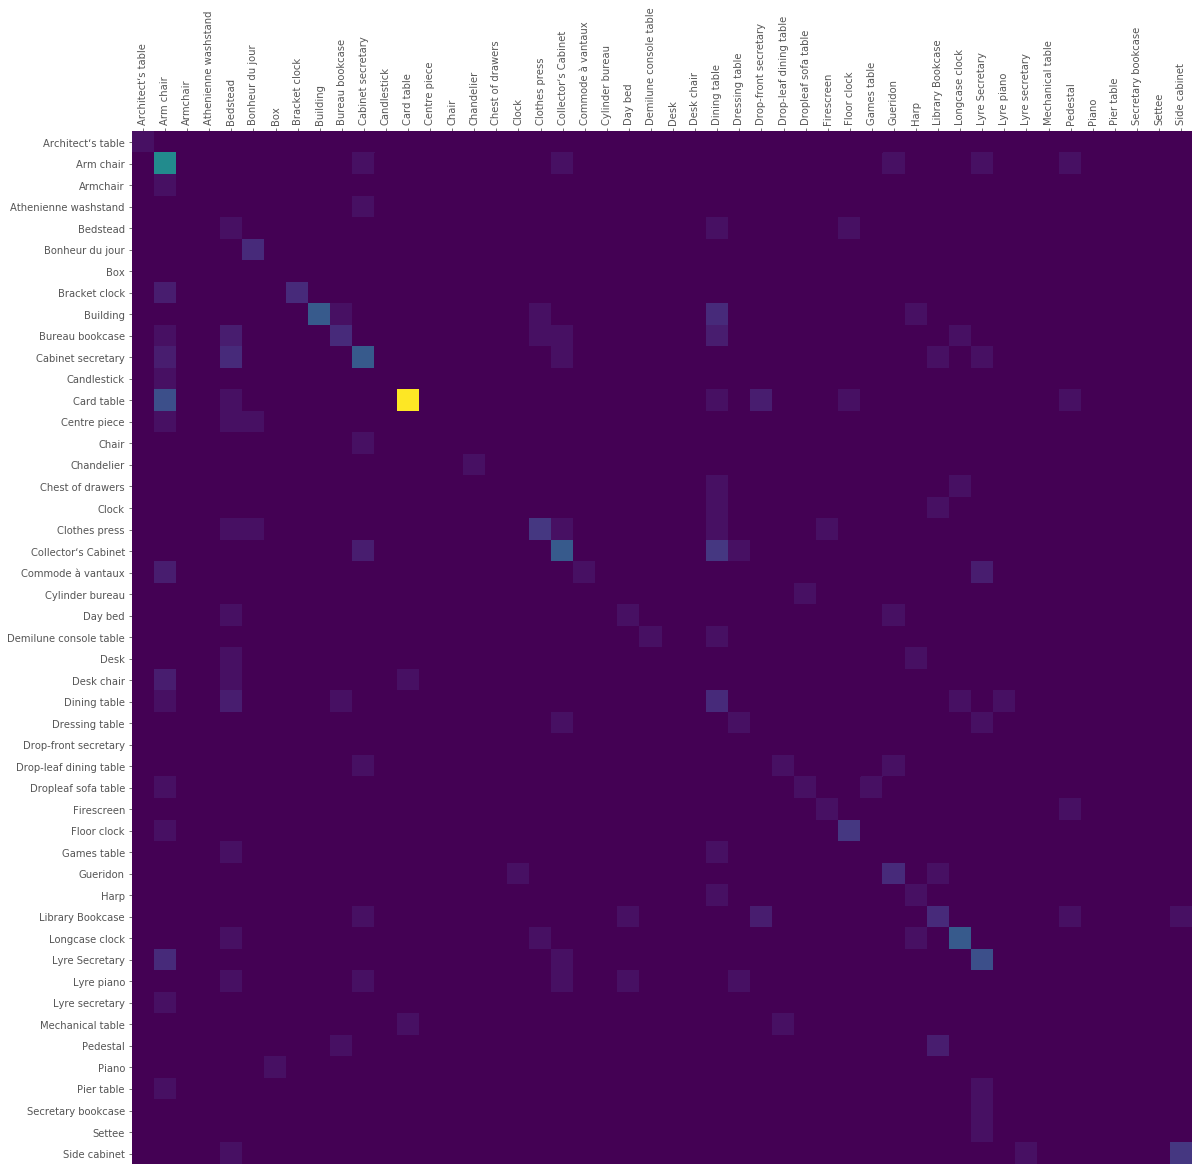

In [147]:
cm = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=pred_all)
plot_confusion_matrix(cm, dp.encoder.classes_, '{}_confusionmatrix'.format(CURRENT_RUN))

In [148]:
cm

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 0, 12,  0, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  4]])

# and now a new net with old parameters

In [59]:
N_DATA_SET = 'neoclassica_1'
N_DATA_DIR = os.path.join(os.getcwd(), '..', 'data', N_DATA_SET)
N_DATA_DIR = os.path.abspath(N_DATA_DIR)
print("Using '{}' as new data directory".format(N_DATA_DIR))
if not os.path.isdir(N_DATA_DIR):
    print("Data dir does not exist")

Using '/home/bernhard/pyvsem/data/neoclassica_1' as new data directory


In [101]:
import lasagne

In [62]:
from pyvsem.neuralnets.datasets.Neoclassica import NeoclassicaProvider
n_dp = NeoclassicaProvider(N_DATA_DIR, 'multi_class')

DEBUG:/home/bernhard/pyvsem/notebooks/../pyvsem/neuralnets/datasets/Neoclassica.py:Neoclassica-Provider using '/home/bernhard/pyvsem/notebooks' as working dir.
DEBUG:/home/bernhard/pyvsem/notebooks/../pyvsem/neuralnets/datasets/Neoclassica.py:Found 2167 images
DEBUG:/home/bernhard/pyvsem/notebooks/../pyvsem/neuralnets/datasets/Neoclassica.py:Found 2167 tag files
DEBUG:/home/bernhard/pyvsem/notebooks/../pyvsem/neuralnets/datasets/Neoclassica.py:Reading all tag files finished in: 0.1 s
INFO:/home/bernhard/pyvsem/notebooks/../pyvsem/neuralnets/datasets/Neoclassica.py:Image count before filtering: 2167
INFO:/home/bernhard/pyvsem/notebooks/../pyvsem/neuralnets/datasets/Neoclassica.py:Filtering tags finished in: 0.0 s
INFO:/home/bernhard/pyvsem/notebooks/../pyvsem/neuralnets/datasets/Neoclassica.py:Remaining images: 2167
INFO:/home/bernhard/pyvsem/notebooks/../pyvsem/neuralnets/datasets/Neoclassica.py:Task is 'multi_class' so only take the first tag for each image.
DEBUG:/home/bernhard/pyvse

In [63]:
# train/test split for neoclassica images
n_x_train, n_x_test, n_y_train, n_y_test = sklearn.cross_validation.train_test_split(n_dp.get_image_paths(), n_dp.get_tags_for_images(), train_size=0.8)
n_x_train = np.array(n_x_train)
n_x_test  = np.array(n_x_test)
n_y_train = np.array(n_y_train)
n_y_test  = np.array(n_y_test)
print("number of train images/test images: {}/{}".format(len(n_x_train), len(n_x_test)))

number of train images/test images: 1733/434


In [64]:
# new training, so track what's happening
on_epoch_finished = [
    nolearn_utils.hooks.PlotTrainingHistory(path=os.path.join(DATA_DIR, "pretrained_{}.pdf".format(CURRENT_RUN))),
    nolearn_utils.hooks.SaveTrainingHistory(path=os.path.join(DATA_DIR, "pretrained_{}_training_history.pickle".format(CURRENT_RUN))),
    nolearn_utils.hooks.EarlyStopping(patience=25)
]

In [65]:
# create new with same options
n_net = net_factory.create_net(
    input_shape=image_shape,
    y=n_dp.get_all_tags(),  # ! note that the new provider is used
    train_iterator=train_iterator,
    test_iterator=test_iterator,
    max_epochs=100,
    on_epoch_finished=on_epoch_finished
)

In [67]:
# restore params (weights, ...) from old net
n_net.load_params_from(os.path.join(DATA_DIR, "{}_params.pickle".format(CURRENT_RUN)))
# of course the two last layers do not match, the number of classes changed

Loaded parameters to layer 'conv1_1' (shape 64x3x3x3).
Loaded parameters to layer 'conv1_1' (shape 64).
Loaded parameters to layer 'conv2_1' (shape 128x64x3x3).
Loaded parameters to layer 'conv2_1' (shape 128).
Loaded parameters to layer 'conv3_1' (shape 256x128x3x3).
Loaded parameters to layer 'conv3_1' (shape 256).
Loaded parameters to layer 'conv_2' (shape 256x256x3x3).
Loaded parameters to layer 'conv_2' (shape 256).
Loaded parameters to layer 'conv4_1' (shape 512x256x3x3).
Loaded parameters to layer 'conv4_1' (shape 512).
Loaded parameters to layer 'conv4_2' (shape 512x512x3x3).
Loaded parameters to layer 'conv4_2' (shape 512).
Loaded parameters to layer 'conv5_1' (shape 512x512x3x3).
Loaded parameters to layer 'conv5_1' (shape 512).
Loaded parameters to layer 'conv5_2' (shape 512x512x3x3).
Loaded parameters to layer 'conv5_2' (shape 512).
Loaded parameters to layer 'fc6' (shape 4608x4096).
Loaded parameters to layer 'fc6' (shape 4096).
Loaded parameters to layer 'fc7' (shape 4096

In [68]:
# new training
n_net.fit(n_x_train, n_y_train)
print("pretrained net was fitted again with new images")

# Neural Network with 45052330 learnable parameters

## Layer information

name      size          total    cap.Y    cap.X    cov.Y    cov.X    filter Y    filter X    field Y    field X
--------  ----------  -------  -------  -------  -------  -------  ----------  ----------  ---------  ---------
input     3x120x120     43200   100.00   100.00   100.00   100.00         120         120        120        120
conv1_1   64x120x120   921600   100.00   100.00     2.50     2.50           3           3          3          3
pool1     64x60x60     230400   100.00   100.00     2.50     2.50           3           3          3          3
conv2_1   128x60x60    460800    85.71    85.71     5.83     5.83           6           6          7          7
pool2     128x30x30    115200    85.71    85.71     5.83     5.83           6           6          7          7
conv3_1   256x30x30    230400    80.00    80.00    12.50    12.50          12          12         15         15
conv_2    256x30x30    230400

/home/bernhard/.anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn_utils.iterators.test_iterator object at 0x7f7435aadb70>,
     batch_iterator_train=<nolearn_utils.iterators.train_iterator object at 0x7f7435aadb00>,
     custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'name': 'input', 'shape': (None, 3, 120, 120)}), (<class 'lasagne.layers.dnn.Conv2DDNNLayer'>, {'pad': 1, 'name': 'conv1_1', 'filter_size': 3, 'num_filters': 64, 'nonlinearity': <function rectify at 0x7f74465bc378>}), (<class 'lasagne.layers.dnn.M...nseLayer'>, {'num_units': 42, 'name': 'fc8', 'nonlinearity': <function softmax at 0x7f74465bc268>})],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x7f744631f7b8>,
     objective_loss_function=<function categorical_crossentropy at 0x7f744624d598>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn_utils.hooks.PlotTrainingHistory object at 0x7f741f25fc88>, <nolearn_utils.hooks.SaveTrainingHistory obje

In [71]:
# note that the validation accuracy is already higher than the 0.08 from the old net

In [72]:
print_log = PrintLog()
print_log(n_net, n_net.train_history_)

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -------
     31       0.23708       3.51060      0.06753      0.42195  120.14s


target class: 'Bougeoirs'
image path:   '/home/bernhard/pyvsem/data/neoclassica_1/images/99.jpg'


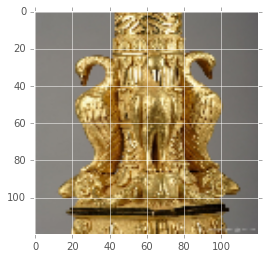

In [75]:
n_TI = 42
print("target class: '{}'".format(n_dp.inverse_transform(n_y_test[n_TI])))
print("image path:   '{}'".format(n_x_test[n_TI]))
im = test_iterator.transform(np.array([n_x_test[n_TI]]), None)[0][0]
im = im.transpose(1, 2, 0)
imshow(im)

In [76]:
# get prediction for the test image
n_pred_test = n_net.predict(np.array([n_x_test[TI]]))

print("predictions:")
print(n_dp.inverse_transform(n_pred_test))

predictions:
['Bougeoirs']


In [77]:
n_pred_all = n_net.predict(np.array(n_x_test))
n_pred_all

array([28, 22, 22, 22,  3, 19, 19,  3, 19, 34, 28, 17, 38,  3, 26, 14, 28,
       38, 19, 13, 26, 19, 17, 32, 26, 13, 31,  3, 22,  3,  3, 17, 34, 32,
       19, 38, 19, 34,  3, 19, 31, 38,  3, 22, 13, 38, 38, 19,  3,  3, 26,
       13, 22, 28, 19, 38, 38, 14,  3,  3, 26, 19, 38, 38, 38, 19, 38, 38,
       32, 34, 14, 32,  3, 10, 28,  3, 28, 22, 19, 22, 38, 19, 38, 38, 32,
       19, 19, 38, 38,  3, 29, 38, 19, 13, 32, 17, 38, 32, 19, 22, 38,  3,
       34, 38, 19, 26, 10, 19, 19, 13, 22, 38, 38, 19, 19,  3, 38, 19, 19,
       38, 19, 26, 19, 28, 18, 32, 22, 34, 19, 19, 22, 31, 19, 28, 22, 17,
       38, 38, 32, 38, 19, 19, 10, 18, 18, 28, 38,  3, 38, 19, 38, 38,  3,
       28,  3, 17, 38, 19, 13, 22, 31, 14, 38, 19, 22,  3, 26, 38, 38, 22,
       31, 22, 28, 28, 38, 19, 10, 17, 28, 38, 22, 26, 19, 38, 29, 35, 22,
       38, 34, 38, 28, 13, 28, 19, 26, 26, 38,  3, 34, 19, 17, 17, 28, 19,
       28, 32, 22, 28, 28, 19,  3, 28, 19, 32, 31, 34, 20, 19, 29, 28, 19,
       26, 14, 26, 28, 38

In [80]:
print("classification report:")
print(sklearn.metrics.classification_report(
        y_true=n_dp.inverse_transform(n_y_test),
        y_pred=n_dp.inverse_transform(n_pred_all),
        digits=6))

classification report:
             precision    recall  f1-score   support

     Altaza   0.000000  0.000000  0.000000         1
       Bett   0.000000  0.000000  0.000000         1
Bilderrahmen   0.000000  0.000000  0.000000         2
  Bougeoirs   0.411765  0.807692  0.545455        26
Buchständer   0.000000  0.000000  0.000000         1
     Buffet   0.000000  0.000000  0.000000         2
Canterburry   0.500000  1.000000  0.666667         1
Cassolettes   0.000000  0.000000  0.000000         1
     Centre   0.000000  0.000000  0.000000         4
   Ensemble   0.800000  0.307692  0.444444        13
    Etagère   0.000000  0.000000  0.000000         1
 Fruchtkorb   0.000000  0.000000  0.000000         3
   Geschirr   0.294118  1.000000  0.454545         5
Halbschrank   0.375000  0.176471  0.240000        17
Handspiegel   0.000000  0.000000  0.000000         1
     Hocker   0.000000  0.000000  0.000000         4
 Kandelaber   0.333333  0.545455  0.413793        11
 Kleinmöbel   1.00000

/home/bernhard/.anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


confusion matrix:


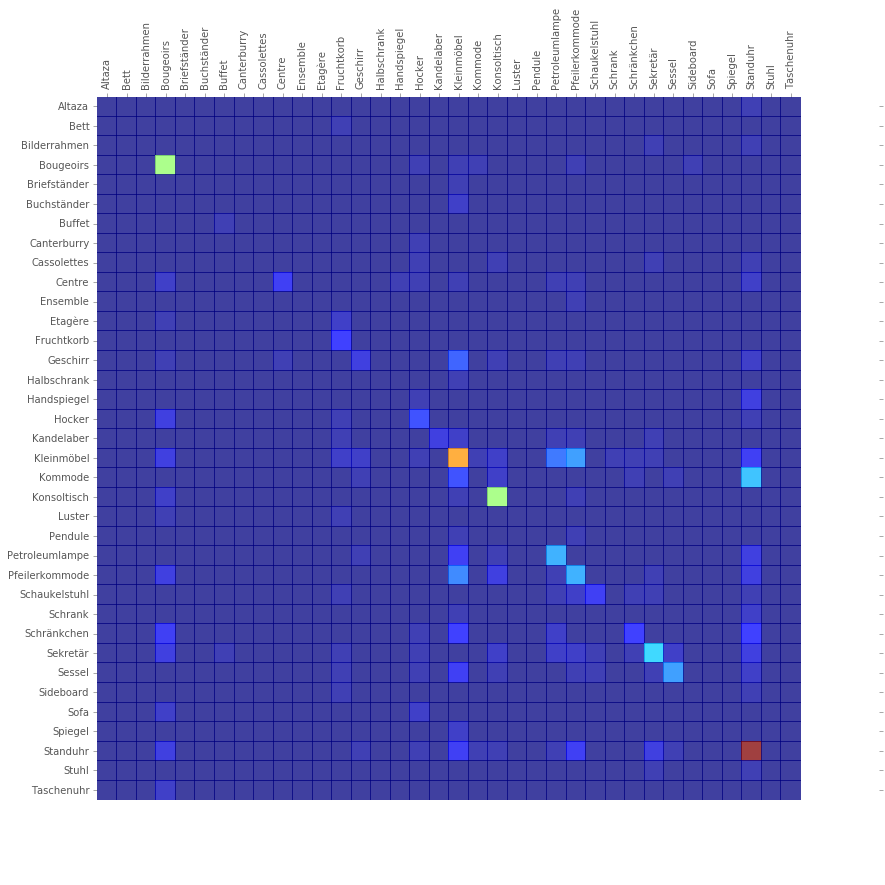

In [81]:
print("confusion matrix:")
cm = sklearn.metrics.confusion_matrix(y_true=n_y_test, y_pred=n_pred_all)
plot_confusion_matrix(cm, n_dp.encoder.classes_)